# Dimensionality Reduction

Dimensionality reduction is a technique used in machine learning and statistics to reduce the number of input variables in a dataset. More input features often make a model more complex, increasing the risk of overfitting and making the model harder to interpret. Dimensionality reduction techniques aim to simplify models without losing much information.

---

### Why is Dimensionality Reduction Important?

1. **Simplification**: Makes the dataset easier to explore and visualize.
2. **Speed**: Reduces the computational complexity, making algorithms run faster.
3. **Data Compression**: Allows for more efficient storage of data.
4. **Noise Reduction**: Helps to eliminate irrelevant features or reduce noise.
5. **Improved Performance**: Can lead to better model performance when irrelevant features are removed.

---

### Example: Customer Segmentation in Retail

Imagine you're a data scientist at a retail company. The company collects data on customer transactions, online activity, customer service interactions, and more. In total, you have hundreds of features for each customer.

**The Problem**: You want to segment your customer base to target marketing more effectively, but the high dimensionality of your data makes it difficult to gain any meaningful insights.

**The Solution**: By applying dimensionality reduction techniques like PCA, you can reduce your hundreds of features to just a few principal components. These components can effectively summarize the essential information in the dataset, making it easier to perform customer segmentation.

**Outcome**: The marketing team can now more effectively tailor strategies for different segments, thereby increasing customer engagement and revenue.

## Overview

1. The curse of dimensionality
2. PCA
3. Factor Analysis
4. Adaptive Methods: t-SNE and UMAP
5. Other techniques and resources

---

# The Curse of Dimensionality

 In high dimensions, the behavior of data can be counterintuitive, and algorithms that work well in low dimensions can become ineffective or computationally expensive.  This is because the available "space" that training samples are embedded grows exponentially with respect to the data.  This has several ramifications:

 - Distances between items become larger
 - Difference between distances become smaller
 - The amount of data required to cover the space grows exponentially

### The Hughes Phenomenon ###

The Hughes Phenomenon shows that as the number of features increases, the classifier’s performance increases as well until we reach the optimal number of features. Adding more features based on the same size as the training set will then degrade the classifier’s performance.

![The Hughes Phenomenon](./assets/hughes_phenomenon.png)

See [this explanation](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/) to help guide your intuitions.

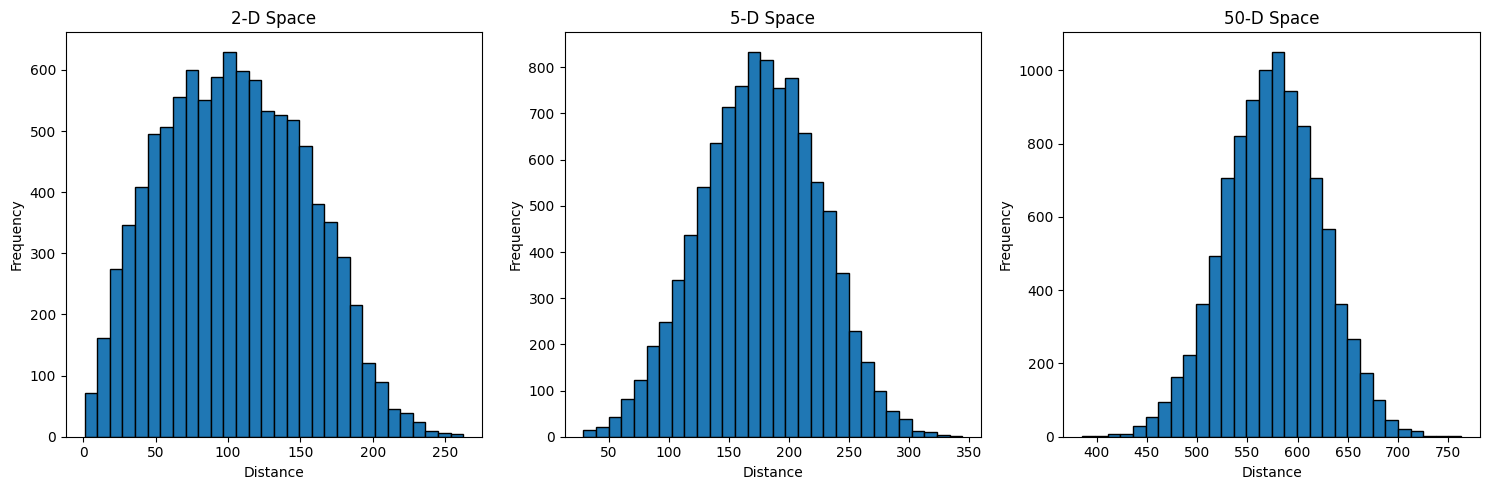

In [4]:
# The following exercise plots a histogram illustrating how distances vary as the number of dimensions increases


import numpy as np
import matplotlib.pyplot as plt

def generate_points(num_points, num_dimensions):
    return[np.random.randint(-100, 100, num_dimensions) for _ in range(num_points)]

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def compute_pairwise_distances(points_x,points_y):
    distances = []
    for i,j in zip(points_x,points_y):
        distances.append(euclidean_distance(i,j))
    return np.array(distances)

# Set the number of points and dimensions
num_points = 10000

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through a few different dimensions
for ax, num_dimensions in zip(axes, [2, 5, 50]):
    # Generate points in unit hypercube
    points_x = generate_points(num_points, num_dimensions)
    points_y = generate_points(num_points, num_dimensions)

    # Compute pairwise distances
    distances = compute_pairwise_distances(points_x,points_y)
    
    # Plot histogram of distances
    ax.hist(distances, bins=30, edgecolor='black')
    ax.set_title(f"{num_dimensions}-D Space")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

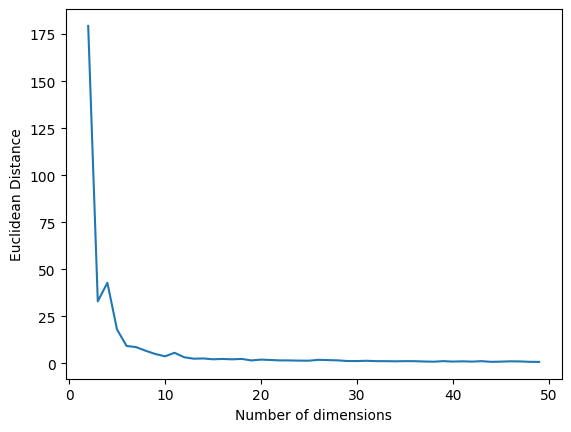

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = (mxd-mnd)/mnd
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Euclidean Distance')
plt.show()

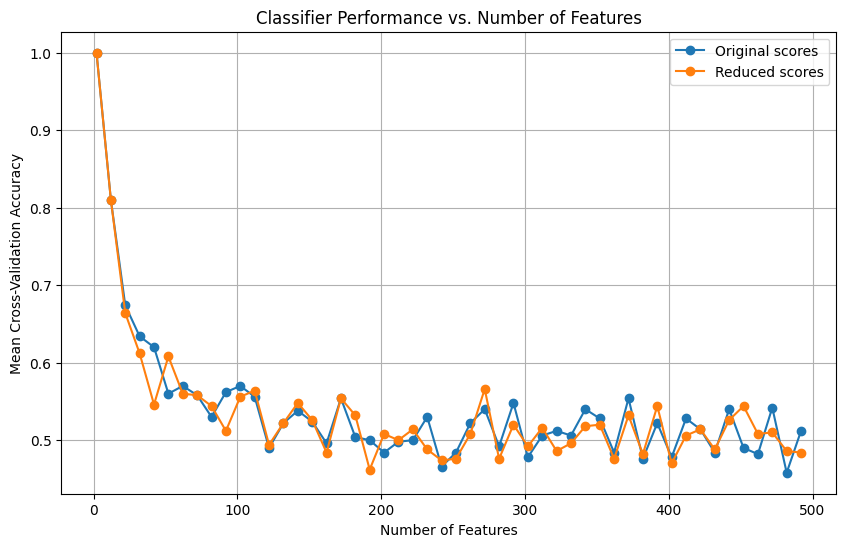

In [110]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import numpy as np

# Initialize variables
n_samples = 500
n_classes = 2
scores = []
reduced_scores = []

def generate_naive_data(n_samples=1000, n_features=50,separation=.2):
    classA_data = np.random.rand(n_samples // 2, n_features)
    #transformation_matrix_subset = np.random.dirichlet(alpha=np.ones(n_informative) * separation, size=n_informative)

    random_vector = np.random.rand(1, n_features) - 0.5
    scaled_vector = (random_vector / np.sum(np.abs(random_vector))) * separation

    # Replicate this row vector to create a matrix of the same shape as Class B data
    scaled_matrix = np.tile(scaled_vector, (n_samples // 2, 1))

    
    classB_data = np.random.rand(n_samples // 2, n_features)+scaled_matrix
    #rotation = np.random.dirichlet(alpha=np.ones(n_features) * alpha, size=n_features)

    #classB_data = classB_data.dot(rotation)

    X = np.vstack((classA_data, classB_data))
    y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    return X,y

# def generate_linear_data(n_samples=1000, n_features=50, n_informative=5, alpha = 1, separation=.5):
#     """
#     Generate synthetic data with two classes based on linear combinations of lower-dimensional data.
    
#     Parameters:
#         - n_samples: The total number of samples.
#         - n_features: The number of features.
#         - n_informative: The number of informative features upon which the higher dimensions are based.
        
#     Returns:
#         - X: The feature matrix.
#         - y: The label vector.
#     """
    
   
#     low_dim_data_0 = np.random.rand(n_samples // 2, n_informative)
#     #transformation_matrix_subset = np.random.dirichlet(alpha=np.ones(n_informative) * separation, size=n_informative)
    
#     low_dim_data_1 = np.random.rand(n_samples // 2, n_informative)+separation
#     transformation_matrix_full = np.random.dirichlet(alpha=np.ones(n_features) * alpha, size=n_informative)
    
    
    
   
#     # Combine into one dataset
#     X = np.vstack((low_dim_data_0, low_dim_data_1))
#     X = X.dot(transformation_matrix_full)
#     y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    
#     return X, y

# Loop through different numbers of features
for n_features in range(2, 500, 10):  # Increasing features from 2 to 100 in steps of 5
    # Generate synthetic data
    #X, y = generate_synthetic_data(n_features = n_features, noise_level=.5, separability=.1)
    #X, y = generate_linear_data(n_samples=n_samples,n_features = n_features, alpha=3, separation=.2, n_informative=10)
    X, y = generate_naive_data(n_samples=n_samples,n_features = n_features,separation=2)
    
    # Initialize and train classifier
    #knn = KNeighborsClassifier()
    knn = KNeighborsClassifier()

    # Evaluate classifier using 5-fold cross-validation
    score = np.mean(cross_val_score(knn, X, y, cv=5, scoring='accuracy'))
    scores.append(score)


    # Now with PCA:
    pipeline = make_pipeline(PCA(n_components=.85),knn)
    reduced_score = np.mean(cross_val_score(pipeline, X, y, cv=5, scoring='accuracy'))
    reduced_scores.append(reduced_score)
    

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2, 500, 10), scores, marker='o', label="Original scores")
plt.plot(range(2, 500, 10), reduced_scores, marker='o', label="Reduced scores")
plt.title('Classifier Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
x = np.array([0,2,3,4,5])
np.sum(x)

array = np.random.rand(10)
array = array - np.mean(array)
array 

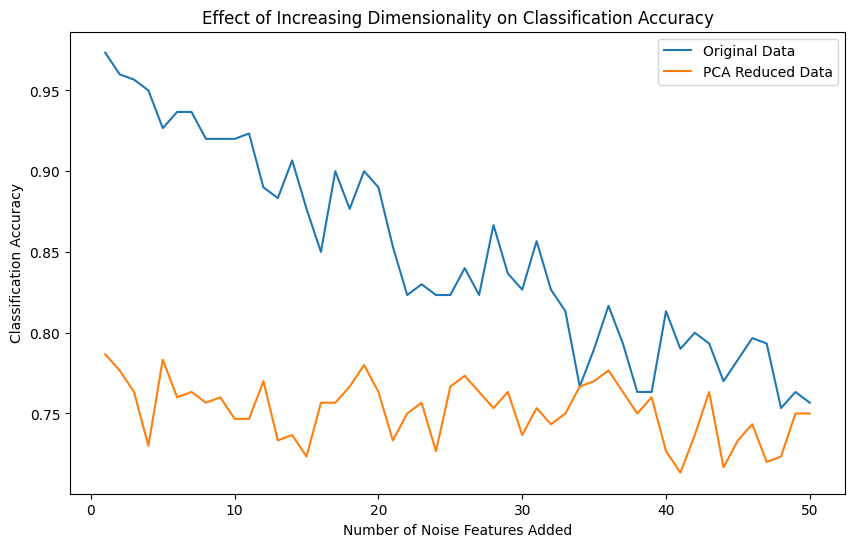

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Generate base synthetic data
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, n_classes=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize lists to hold accuracies
original_accuracies = []
reduced_accuracies = []

# Step 2 & 3: Add noise features and evaluate classifier
for i in range(1, 51):  # Adding up to 50 noise features
    noise = np.random.normal(size=(X_train.shape[0], i))
    X_train_noise = np.hstack([X_train, noise])
    
    noise = np.random.normal(size=(X_test.shape[0], i))
    X_test_noise = np.hstack([X_test, noise])
    
    knn = KNeighborsClassifier()
    knn.fit(X_train_noise, y_train)
    y_pred = knn.predict(X_test_noise)
    
    acc = accuracy_score(y_test, y_pred)
    original_accuracies.append(acc)

# Step 4: Apply dimensionality reduction and re-evaluate
from sklearn.decomposition import PCA

for i in range(1, 51):
    noise = np.random.normal(size=(X_train.shape[0], i))
    X_train_noise = np.hstack([X_train, noise])
    
    noise = np.random.normal(size=(X_test.shape[0], i))
    X_test_noise = np.hstack([X_test, noise])
    
    pca = PCA(n_components=2)
    X_train_reduced = pca.fit_transform(X_train_noise)
    X_test_reduced = pca.transform(X_test_noise)
    
    knn = KNeighborsClassifier()
    knn.fit(X_train_reduced, y_train)
    y_pred = knn.predict(X_test_reduced)
    
    acc = accuracy_score(y_test, y_pred)
    reduced_accuracies.append(acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), original_accuracies, label='Original Data')
plt.plot(range(1, 51), reduced_accuracies, label='PCA Reduced Data')
plt.xlabel('Number of Noise Features Added')
plt.ylabel('Classification Accuracy')
plt.title('Effect of Increasing Dimensionality on Classification Accuracy')
plt.legend()
plt.show()

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a synthetic dataset with a large number of features
X, y = make_classification(n_samples=1000, n_features=1000, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier's accuracy on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy before PCA: {accuracy}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Reduce to 50 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classifier on the reduced data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

# Evaluate the classifier's accuracy on the test data
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy after PCA: {accuracy}")


Accuracy before PCA: 0.86
Accuracy after PCA: 0.73
